In [21]:
import pandas as pd

# 1. Cargar el archivo
df = pd.read_csv('../data/raw/jugadores.csv')

# 2. Seleccionar columnas de interés
# He elegido: Nombre, Nación, Posición, Equipo, Edad, Minutos, Goles, Asistencias, xG, xAG (Asistencias esperadas) y Progresión.
columnas_interes = [
    'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Min', '90s',
    'Gls', 'Ast', 'G+A', 'G-PK', 'xG', 'npxG', 'xAG', 'PrgC', 'PrgP'
]

df_clean = df[columnas_interes].copy()

# 3. Limpieza de datos
# Quitamos el prefijo de la nación (ej: 'es ESP' -> 'ESP')
df_clean['Nation'] = df_clean['Nation'].str.split(' ').str[-1]

# 4. Cálculo de Eficiencia Propia
df_clean['Gls_per90'] = (df_clean['Gls'] / df_clean['Min']) * 90
df_clean['xG_per90'] = (df_clean['xG'] / df_clean['Min']) * 90

# 5. Métrica de "Diferencial de Finalización"
# Un valor positivo significa que el jugador marca más de lo esperado
df_clean['Finishing_Diff'] = df_clean['Gls'] - df_clean['xG']

# 6. Filtrado de ruido
# Para que el análisis sea relevante, eliminamos jugadores con menos de 450 min (5 partidos)
df_final = df_clean[df_clean['Min'] >= 450].copy()

# Guardar el archivo limpio en tu carpeta de procesados
df_final.to_csv('../data/processed/jugadores_limpios.csv', index=False)

print("¡Dataset limpiado! Total de jugadores analizados:", len(df_final))
print(df_final[['Player', 'Gls', 'xG', 'Finishing_Diff']].sort_values(by='Finishing_Diff', ascending=False).head())

¡Dataset limpiado! Total de jugadores analizados: 1963
                   Player  Gls    xG  Finishing_Diff
2542    Alexander Sørloth   23  12.3            10.7
885            Phil Foden   19  10.3             8.7
265       Jude Bellingham   19  11.1             7.9
1412  Alexandre Lacazette   19  11.4             7.6
1064      Serhou Guirassy   28  20.8             7.2


Ahora realizarmemos un grafico de dispersión para comparar el xG con los goles reales y así poder ver quiénes son los jugadores más eficientes de la lista.
En el eje X pondremos el xG (Goles Esperados) y en el eje Y los Goles Reales.
- Los jugadores que estén por encima de la línea diagonal son los "killers": finalizan mejor de lo que la estadística predice.
- Los que están por debajo están pasando por una mala racha o tienen problemas de definición.

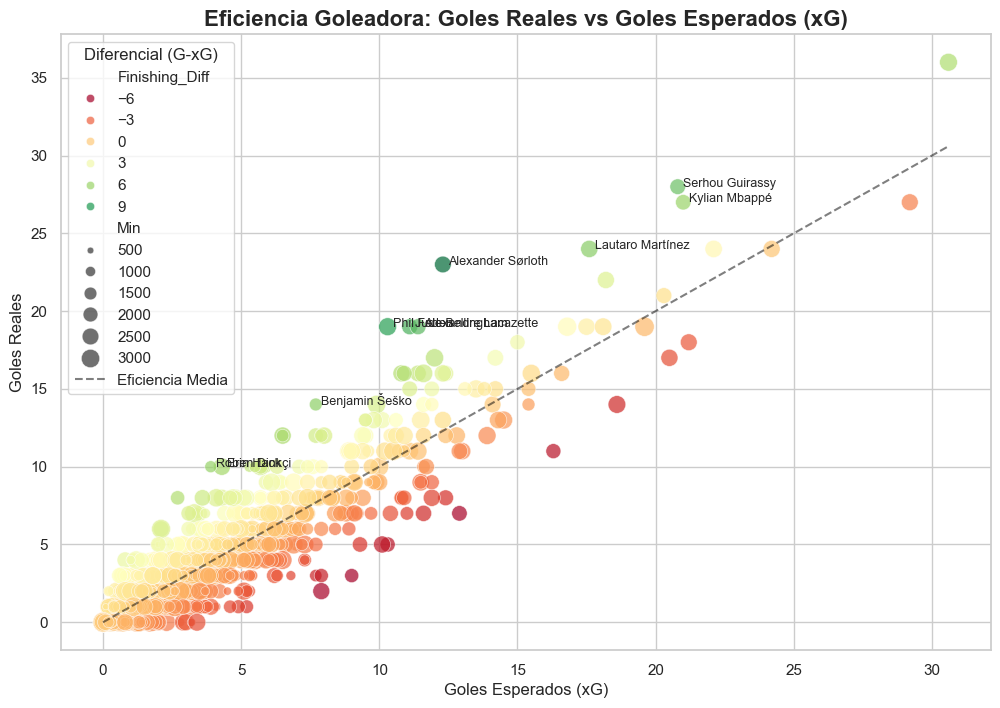

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configurar el estilo visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# 2. Crear el gráfico de dispersión
# Usamos el dataframe 'df_final' que creamos en el paso anterior
ax = sns.scatterplot(
    data=df_final, 
    x='xG', 
    y='Gls', 
    size='Min', 
    hue='Finishing_Diff', 
    palette='RdYlGn', # Rojo (poco eficiente) a Verde (muy eficiente)
    sizes=(20, 200),
    alpha=0.7
)

# 3. Dibujar la línea de "Eficiencia Perfecta" (Goles == xG)
line_coords = [0, df_final['xG'].max()]
plt.plot(line_coords, line_coords, color='black', linestyle='--', alpha=0.5, label='Eficiencia Media')

# 4. Etiquetar a los mejores (Top 10 por diferencial)
top_players = df_final.sort_values(by='Finishing_Diff', ascending=False).head(10)
for i, player in top_players.iterrows():
    plt.text(player['xG']+0.2, player['Gls'], player['Player'], fontsize=9)

# 5. Personalización estética
plt.title('Eficiencia Goleadora: Goles Reales vs Goles Esperados (xG)', fontsize=16, fontweight='bold')
plt.xlabel('Goles Esperados (xG)', fontsize=12)
plt.ylabel('Goles Reales', fontsize=12)
plt.legend(title='Diferencial (G-xG)')

# 6. Guardar el gráfico
plt.savefig('../visuals/scatter_eficiencia.png', dpi=300, bbox_inches='tight')

plt.show()

A continuación vamos a añadir la tabla con los 20 jugadores más eficientes para  que sea más legible la gráfica:


In [23]:
# 1. Obtener los 20 mejores por diferencial de finalización
top_20_eficientes = df_final.sort_values(by='Finishing_Diff', ascending=False).head(20)

# 2. Seleccionar solo las columnas que queremos mostrar para que sea legible
tabla_top = top_20_eficientes[['Player', 'Squad', 'Gls', 'xG', 'Finishing_Diff']]

# 3. Mostrar la tabla formateada
print("--- LOS 20 JUGADORES MÁS EFICIENTES ---")
display(tabla_top)

--- LOS 20 JUGADORES MÁS EFICIENTES ---


,Player,Squad,Gls,xG,Finishing_Diff
2542,Alexander Sørloth,Villarreal,23,12.3,10.7
885,Phil Foden,Manchester City,19,10.3,8.7
265,Jude Bellingham,Real Madrid,19,11.1,7.9
1412,Alexandre Lacazette,Lyon,19,11.4,7.6
1064,Serhou Guirassy,Stuttgart,28,20.8,7.2
1643,Lautaro Martínez,Inter,24,17.6,6.4
2414,Benjamin Šeško,RB Leipzig,14,7.7,6.3
1084,Robin Hack,Gladbach,10,3.9,6.1
1690,Kylian Mbappé,Paris S-G,27,21.0,6.0
719,Eren Dinkçi,Heidenheim,10,4.3,5.7


Para interpretas la siguiente gráfica nos podemos fijar en la columna Finishing_Diff:
- En esta columna observamos cuántos goles más han marcado de lo que la probabilidad de sus tiros sugería (xG).

A continuación realizaremos otro analisis de eficiencia pero esta vez para las **Asistencias Reales vs Asistencias Esperadas (xAG)**.

Calcularemos quienes son los "Generadores de oro":
- xAG (Expected Assisted Goals): Mide la probabilidad de que un pase se convierta en asistencia.
- PrgP (Progession): Pases que mueven el balón significativamente hacia la porteria contraria.

--- LOS 10 ASISTENTES MÁS EFECTIVOS (Superan su xAG) ---
           Player           Squad  Ast  xAG  Assist_Diff  PrgP
    Ollie Watkins     Aston Villa   13  7.3          5.7  55.0
    Nico Williams   Athletic Club   11  5.7          5.3  66.0
 Jan-Niklas Beste      Heidenheim   11  5.7          5.3  57.0
            Rodri Manchester City    9  3.9          5.1 376.0
Ermedin Demirović        Augsburg    9  3.9          5.1  60.0
  Niclas Füllkrug        Dortmund    8  3.1          4.9  49.0
       Alex Baena      Villarreal   14  9.2          4.8 165.0
     Paulo Dybala            Roma    9  4.3          4.7 122.0
       Pedro Neto          Wolves    9  4.4          4.6  54.0
  Victor Boniface      Leverkusen    8  3.7          4.3  34.0


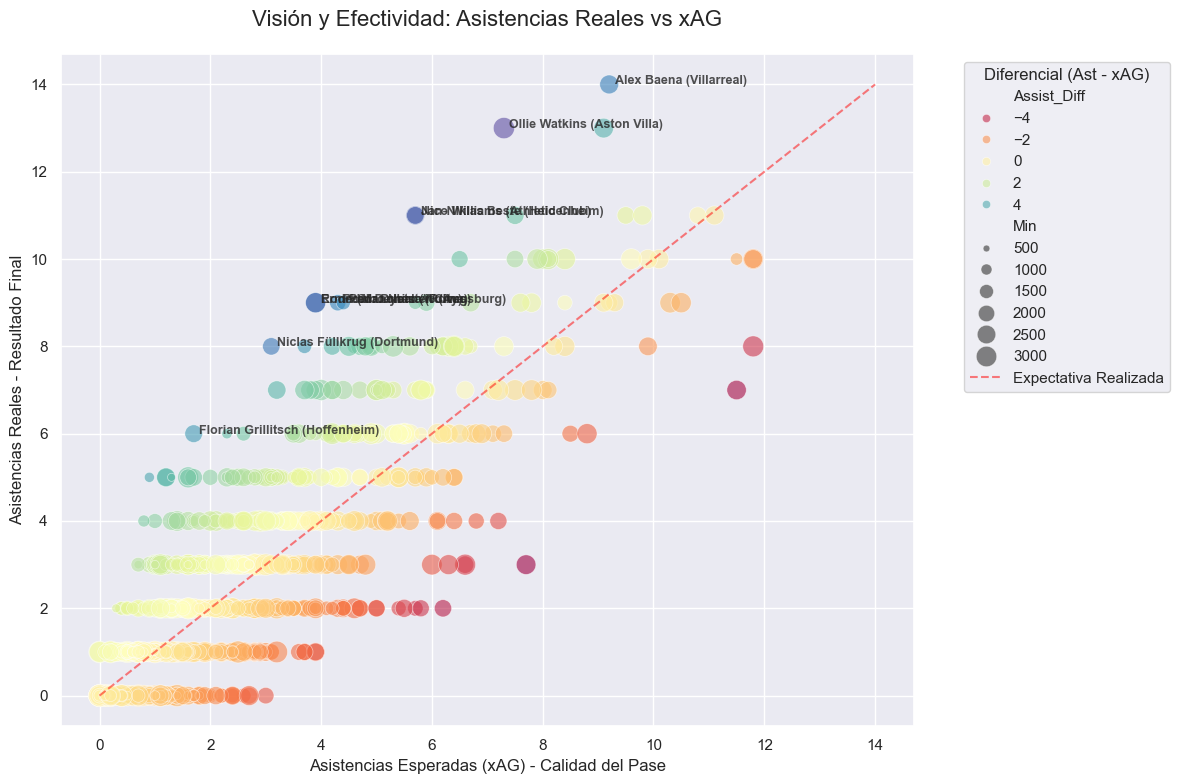

In [24]:
# 1. Creamos un filtro: Solo jugadores que generan mucho (xAG alto) 
# Y que además tienen un diferencial positivo o neutro (sus pases se aprovechan)
df_final['Assist_Diff'] = df_final['Ast'] - df_final['xAG']
df_creadores_top = df_final[df_final['xAG'] > 2.0].copy() # Filtro de calidad mínima

# 2. Ordenamos por el diferencial (Assist_Diff) 
# Esto nos dará a los que están "enrachados" o dan pases de gol clarísimos
top_10_asistentes_reales = df_creadores_top.sort_values(by='Assist_Diff', ascending=False).head(10)

print("--- LOS 10 ASISTENTES MÁS EFECTIVOS (Superan su xAG) ---")
print(top_10_asistentes_reales[['Player', 'Squad', 'Ast', 'xAG', 'Assist_Diff', 'PrgP']].to_string(index=False))

# 3. Configurar el estilo
plt.figure(figsize=(12, 8))
sns.set_theme(style="darkgrid")

# 4. Crear el gráfico de dispersión
# Usamos 'Assist_Diff' para el color: los más "efectivos" resaltarán en verde/azul
scatter = sns.scatterplot(
    data=df_final,
    x='xAG',
    y='Ast',
    hue='Assist_Diff',
    palette='Spectral', # Escala de colores vibrante
    size='Min',
    sizes=(20, 250),
    alpha=0.6,
    edgecolor='w'
)

# 5. Línea de referencia (Asistencias = xAG)
max_val = max(df_final['xAG'].max(), df_final['Ast'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', alpha=0.5, label='Expectativa Realizada')

# 6. Etiquetar a los 10 mejores por diferencial (los que te interesan)
top_asistentes = df_final.sort_values(by='Assist_Diff', ascending=False).head(10)

for i, player in top_asistentes.iterrows():
    plt.text(
        player['xAG'] + 0.1, 
        player['Ast'], 
        f"{player['Player']} ({player['Squad']})", 
        fontsize=9, 
        fontweight='semibold',
        alpha=0.8
    )

# 7. Títulos y etiquetas
plt.title('Visión y Efectividad: Asistencias Reales vs xAG', fontsize=16, pad=20)
plt.xlabel('Asistencias Esperadas (xAG) - Calidad del Pase', fontsize=12)
plt.ylabel('Asistencias Reales - Resultado Final', fontsize=12)
plt.legend(title='Diferencial (Ast - xAG)', bbox_to_anchor=(1.05, 1), loc='upper left')

# 8. Guardar y mostrar
plt.tight_layout()
plt.savefig('../visuals/scatter_asistencias_top.png', dpi=300)
plt.show()

Como se puede ver esta tabla está ordenada de mayor a menor en los jugadores cuya diferencia de asistencias y xAG es mayor, ya que si lo ordenamos por PrgP podemos observar como cambian los jugadores:

--- TOP 10 MOTORES DEL JUEGO (Más Pases Progresivos) ---
             Player           Squad   Pos  PrgP  xAG  Ast
       Granit Xhaka      Leverkusen    MF 392.0  2.7    0
              Rodri Manchester City    MF 376.0  3.9    9
    Martin Ødegaard         Arsenal    MF 344.0  9.6   10
Giovanni Di Lorenzo          Napoli    DF 304.0  4.9    6
        Pascal Groß        Brighton MF,DF 302.0  8.1   10
    Bruno Fernandes  Manchester Utd MF,FW 297.0 11.8    8
   Kirian Rodríguez      Las Palmas    MF 296.0  1.6    2
       Aleix García          Girona    MF 294.0  5.5    6
         Toni Kroos     Real Madrid    MF 290.0  4.9    8
   Maxence Caqueret            Lyon    MF 286.0  6.0    3


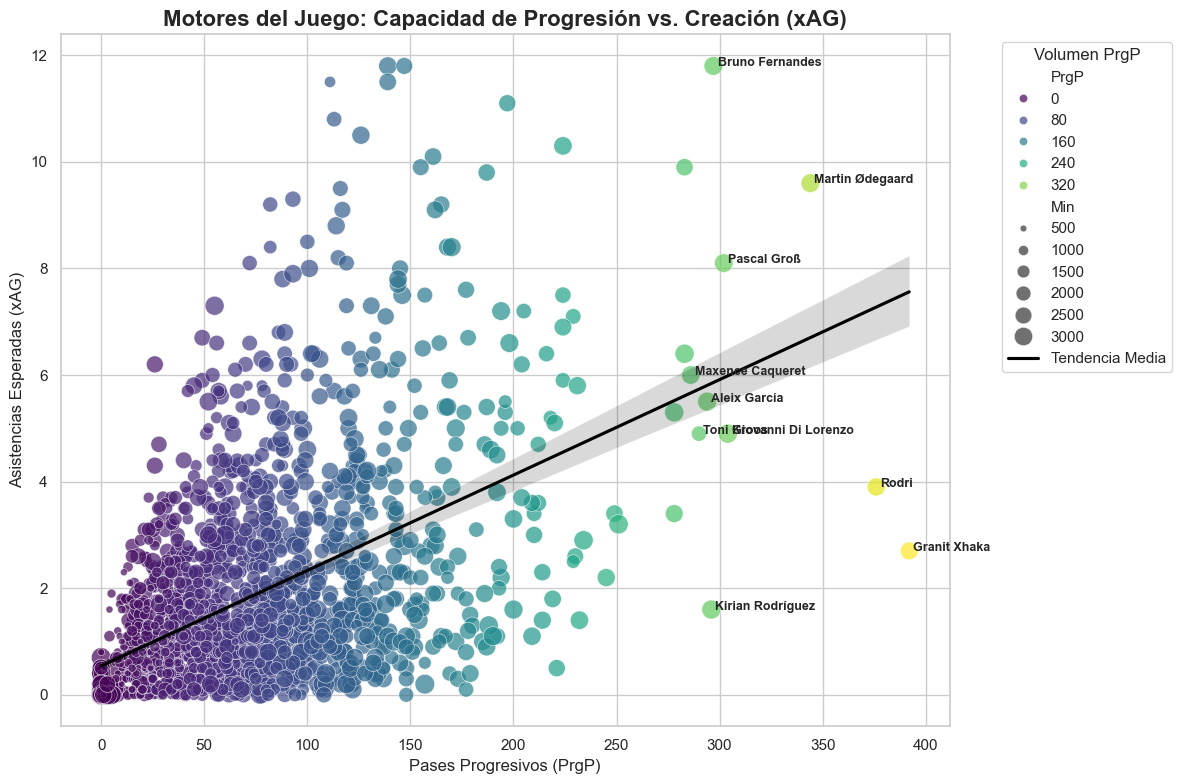

In [25]:
# 1. Filtrar jugadores con un mínimo de minutos para que el promedio sea real
# Y ordenamos por Pases Progresivos (PrgP)
top_motores = df_final.sort_values(by='PrgP', ascending=False).head(10)

print("--- TOP 10 MOTORES DEL JUEGO (Más Pases Progresivos) ---")
print(top_motores[['Player', 'Squad', 'Pos', 'PrgP', 'xAG', 'Ast']].to_string(index=False))

# 2. Configurar el estilo visual (igual que el de goles)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# 3. Crear el gráfico de dispersión
# Eje X: Pases Progresivos | Eje Y: xAG (Asistencias Esperadas)
ax = sns.scatterplot(
    data=df_final, 
    x='PrgP', 
    y='xAG', 
    size='Min', 
    hue='PrgP', # El color resalta a los que más progresan
    palette='viridis', 
    sizes=(20, 200),
    alpha=0.7
)

# 4. Dibujar la línea de tendencia media
# Esto ayuda a ver quiénes dan muchos pases progresivos pero quizás no llegan a zona de asistencia
sns.regplot(data=df_final, x='PrgP', y='xAG', scatter=False, color='black', label='Tendencia Media')

# 5. Etiquetar a los 10 mejores por PrgP
top_motores = df_final.sort_values(by='PrgP', ascending=False).head(10)
for i, player in top_motores.iterrows():
    plt.text(
        player['PrgP'] + 2, 
        player['xAG'], 
        player['Player'], 
        fontsize=9, 
        fontweight='semibold'
    )

# 6. Personalización estética
plt.title('Motores del Juego: Capacidad de Progresión vs. Creación (xAG)', fontsize=16, fontweight='bold')
plt.xlabel('Pases Progresivos (PrgP)', fontsize=12)
plt.ylabel('Asistencias Esperadas (xAG)', fontsize=12)
plt.legend(title='Volumen PrgP', bbox_to_anchor=(1.05, 1), loc='upper left')

# 7. Guardar para tu repositorio
plt.tight_layout()
plt.savefig('../visuals/scatter_motores_juego.png', dpi=300)

plt.show()

En el diagrama de dispersión anterior podemos observar como el jugador con mayor capacidad de progresión, es decir, el jugador que más pases peligrosos hacia área rival realiza **NO TIENE ASISTENCIAS**, esto se debe a que sus compañeros de equipo no aprovechan sus pases, por ello es que realizamos este analisis también ya que no solo nos podemos fijar en la cantidad de asistencias.

A continuación vamos a crear un **Mapa de Calor de Correlación**:
- Este grafico muestra que estadísticas están relacionadas entre sí. Asi demostraría visualmente que los jugadores con mas **pases progresivos** suelen tener más **asistencias**.

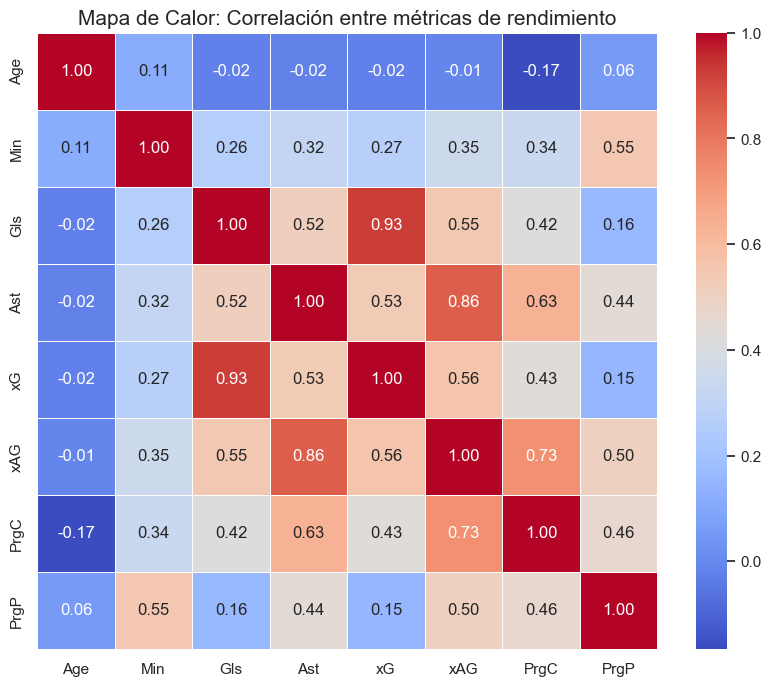

In [26]:
# 1. Seleccionamos las métricas numéricas más importantes
corr_matrix = df_final[['Age', 'Min', 'Gls', 'Ast', 'xG', 'xAG', 'PrgC', 'PrgP']].corr()

# 2. Configurar el gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Mapa de Calor: Correlación entre métricas de rendimiento', fontsize=15)
plt.savefig('../visuals/heatmap_correlacion.png', dpi=300)
plt.show()

De este mapa de calor podemos observar lo siguiente:
- El PrgP está significativamente relacionado con la cantidad de minutos jugados y con las xAG, por lo tanto cuanto mayor PrgP mayor xAG.
- Podemos observar también que el PrgC (Conducción de balón Progresiva) está muy relacionado con la cantidad de asistencias y con las asistencias esperadas.

Vamos a realizar un análisis de la **Evolucion** de diversor jugadores jóvenes.


In [27]:
# 1. Definir el umbral de "Promesa" (Under 21)
u21_players = df_final[df_final['Age'] <= 21].copy()

# 2. Calcular una métrica de impacto total: Goles + Asistencias por 90 min
u21_players['Impact_90'] = (u21_players['G+A'] / u21_players['Min']) * 90

# 3. Ordenar por impacto y pases progresivos (evolución del juego)
top_promesas = u21_players.sort_values(by='Impact_90', ascending=False).head(10)

# 4. Mostrar el Top 10 de jóvenes a seguir
print("--- TOP 10 PROMESAS (U21) POR IMPACTO DIRECTO ---")
print(top_promesas[['Player', 'Age', 'Squad', 'G+A', 'PrgP', 'Impact_90']].to_string(index=False))


--- TOP 10 PROMESAS (U21) POR IMPACTO DIRECTO ---
         Player  Age          Squad  G+A  PrgP  Impact_90
    Cole Palmer 21.0        Chelsea   33 197.0   1.139241
  Michael Olise 21.0 Crystal Palace   16  78.0   1.129412
 Kamory Doumbia 20.0          Brest   11  48.0   1.126280
     Mathys Tel 18.0  Bayern Munich   12  27.0   1.028571
    Adam Hložek 21.0     Leverkusen    5  13.0   0.980392
Jude Bellingham 20.0    Real Madrid   25 196.0   0.971922
     Jhon Durán 19.0    Aston Villa    5   9.0   0.947368
 Benjamin Šeško 20.0     RB Leipzig   16  22.0   0.943644
  Mohamed Bamba 21.0        Lorient   11  16.0   0.869947
  Ibrahim Salah 21.0         Rennes    5  18.0   0.858779
